In [65]:
import yaml
import mysql.connector
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

plt.style.use('fivethirtyeight') #https://matplotlib.org/stable/gallery/style_sheets/fivethirtyeight.html




import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# Load the YAML file
with open("D:\Telangana_Growth_Analysis\db_config.yaml", 'r') as file:
    db_config = yaml.safe_load(file)

# Connect to the database
connection = mysql.connector.connect(**db_config)
cursor = connection.cursor()

![Image](https://drive.google.com/uc?export=download&id=1FDWY3xNgo3ounB-QJaQazWJloBqTKd0B)


### EDA

In [33]:
# SQL query to join 'fact_stamps' and 'dim_districts' on 'dist_code'

query = """
    select * from documents
    inner join districts on documents.dist_code = districts.dist_code
    """
# Use pandas to run the query and store the result in a DataFrame
stamps = pd.read_sql(query, connection)

# Sort the DataFrame by the 'id' column in ascending order
stamps.sort_values(by='id', ascending=True, inplace=True)
stamps.reset_index(drop=True, inplace=True)


# Load the 'dim_date' table into a DataFrame
dim_date = pd.read_sql("SELECT * FROM dim_date", connection)

# Merge the 'stamps' DataFrame with the 'dim_date' DataFrame on the 'month' column
stamps = pd.merge(stamps, dim_date, on='month', how='inner')
# Display the first few rows of the merged DataFrame
stamps.head()

,id,dist_code,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,dist_code,district,mmm,quarter,fiscal_year
0,1,14_1,2019-04-01,4533,59236363.0,0,0.0,14_1,Mahabubnagar\r,Apr,Q1,2019
1,2,17_3,2019-04-01,4151,41508762.0,0,0.0,17_3,Siddipet\r,Apr,Q1,2019
2,3,20_3,2019-04-01,2116,23674170.0,0,0.0,20_3,Rajanna Sircilla\r,Apr,Q1,2019
3,4,21_5,2019-04-01,1089,15915285.0,0,0.0,21_5,Mahabubabad\r,Apr,Q1,2019
4,5,23_1,2019-04-01,6133,82593256.0,0,0.0,23_1,Nalgonda\r,Apr,Q1,2019


In [34]:
#The \r is a carriage return character. 
# it can remove it from the district column using the str.replace method provided by pandas.

stamps['district'] = stamps['district'].str.replace('\r', '')

# drop dis_code
stamps.drop(columns=['dist_code','dist_code'], inplace=True)

stamps.head()

,id,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,district,mmm,quarter,fiscal_year
0,1,2019-04-01,4533,59236363.0,0,0.0,Mahabubnagar,Apr,Q1,2019
1,2,2019-04-01,4151,41508762.0,0,0.0,Siddipet,Apr,Q1,2019
2,3,2019-04-01,2116,23674170.0,0,0.0,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,1089,15915285.0,0,0.0,Mahabubabad,Apr,Q1,2019
4,5,2019-04-01,6133,82593256.0,0,0.0,Nalgonda,Apr,Q1,2019


In [35]:
stamps.info() 
# No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1504 non-null   int64  
 1   month                     1504 non-null   object 
 2   documents_registered_cnt  1504 non-null   int64  
 3   documents_registered_rev  1504 non-null   float64
 4   estamps_challans_cnt      1504 non-null   int64  
 5   estamps_challans_rev      1504 non-null   float64
 6   district                  1504 non-null   object 
 7   mmm                       1504 non-null   object 
 8   quarter                   1504 non-null   object 
 9   fiscal_year               1504 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 117.6+ KB


In [36]:
# change date to datetime type

stamps['month'] = pd.to_datetime(stamps['month'])

In [37]:
stamps.describe()

,id,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,fiscal_year
count,1504.000000,1504,1504.000000,1.504000e+03,1504.000000,1.504000e+03,1504.000000
mean,752.500000,2021-03-13 10:43:24.255319040,3238.007314,1.962961e+08,1944.861037,1.467299e+08,2020.489362
min,1.000000,2019-04-01 00:00:00,0.000000,0.000000e+00,0.000000,0.000000e+00,2019.000000
25%,376.750000,2020-03-01 00:00:00,1013.500000,1.840655e+07,0.000000,0.000000e+00,2019.000000
50%,752.500000,2021-03-01 00:00:00,1964.500000,3.512241e+07,805.000000,1.799040e+07,2020.000000
75%,1128.250000,2022-04-01 00:00:00,3952.500000,9.339799e+07,2198.000000,5.299411e+07,2022.000000
max,1504.000000,2023-03-01 00:00:00,31310.000000,4.073496e+09,30526.000000,4.294273e+09,2022.000000
std,434.311716,NaN,4196.002256,5.224591e+08,3740.305328,4.963718e+08,1.127834


from above observed that documents_registered_cnt has min 0, lets dig deeper

In [48]:
grouped_data = stamps.groupby('month').agg({
    'documents_registered_cnt': 'sum',
    'documents_registered_rev': 'sum',
    'estamps_challans_cnt': 'sum',
    'estamps_challans_rev': 'sum'
}).reset_index()

# Function to plot individual columns with specified color
def plot_individual_column(column_name, title, color):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data[column_name], 
                             mode='lines+markers',
                             line=dict(color=color)))
    fig.update_layout(title=title,
                      xaxis_title='Month/Year',
                      yaxis_title='Value',
                      template="plotly_dark")
    fig.show()

# Plot for 'Documents Registered Count' in blue
plot_individual_column('documents_registered_cnt', 'Monthly Trends for Documents Registered Count', 'blue')

# Plot for 'Documents Registered Revenue' in green
plot_individual_column('documents_registered_rev', 'Monthly Trends for Documents Registered Revenue', 'green')

# Plot for 'E-stamps Challans Count' in red
plot_individual_column('estamps_challans_cnt', 'Monthly Trends for E-stamps Challans Count', 'red')

# Plot for 'E-stamps Challans Revenue' in purple
plot_individual_column('estamps_challans_rev', 'Monthly Trends for E-stamps Challans Revenue', 'purple')


## Problem Statement 1 
#### 1. How does the revenue generated from document registration vary across districts in Telangana? List down the top 5 districts that showed the highest document registration revenue growth between FY 2019 and 2022.

In [58]:
stamps.columns

Index(['id', 'month', 'documents_registered_cnt', 'documents_registered_rev',
       'estamps_challans_cnt', 'estamps_challans_rev', 'district', 'mmm',
       'quarter', 'fiscal_year'],
      dtype='object')

#### Revenue Analysis Across Districts
To understand how the revenue from document registration varies across districts, we can group the data by district and sum the documents_registered_rev.

In [60]:
districts_revenue = stamps.groupby('district')['documents_registered_rev'].sum().reset_index()

districts_revenue.head(50)

,district,documents_registered_rev
0,Adilabad,1.066971e+09
1,Bhadradri Kothagudem,8.247127e+08
2,Hanumakonda,7.927494e+09
3,Hyderabad,3.839674e+10
4,Jagtial,1.666081e+09
5,Jangoan,1.329899e+09
6,Jogulamba Gadwal,9.787797e+08
7,Kamareddy,1.396196e+09
8,Karimnagar,4.024475e+09
9,Khammam,5.606142e+09


In [64]:
# Convert Revenue to Millions
districts_revenue['documents_registered_rev'] = districts_revenue['documents_registered_rev'] / 1e6  # Convert to millions


fig = px.bar(districts_revenue, 
             x='documents_registered_rev', 
             y='district', 
             orientation='h', 
             title='Revenue from Document Registration by District (in Millions)',
             labels={'documents_registered_rev': 'Revenue (in Millions)', 'district': 'District'},
             color='district',  # Assigning color based on district
             color_discrete_sequence=px.colors.qualitative.Set1  # Using a color palette
            )  # Display district names on bars

# Remove legend and adjust vertical size
fig.update_layout(showlegend=False, height=1000)

fig.show()

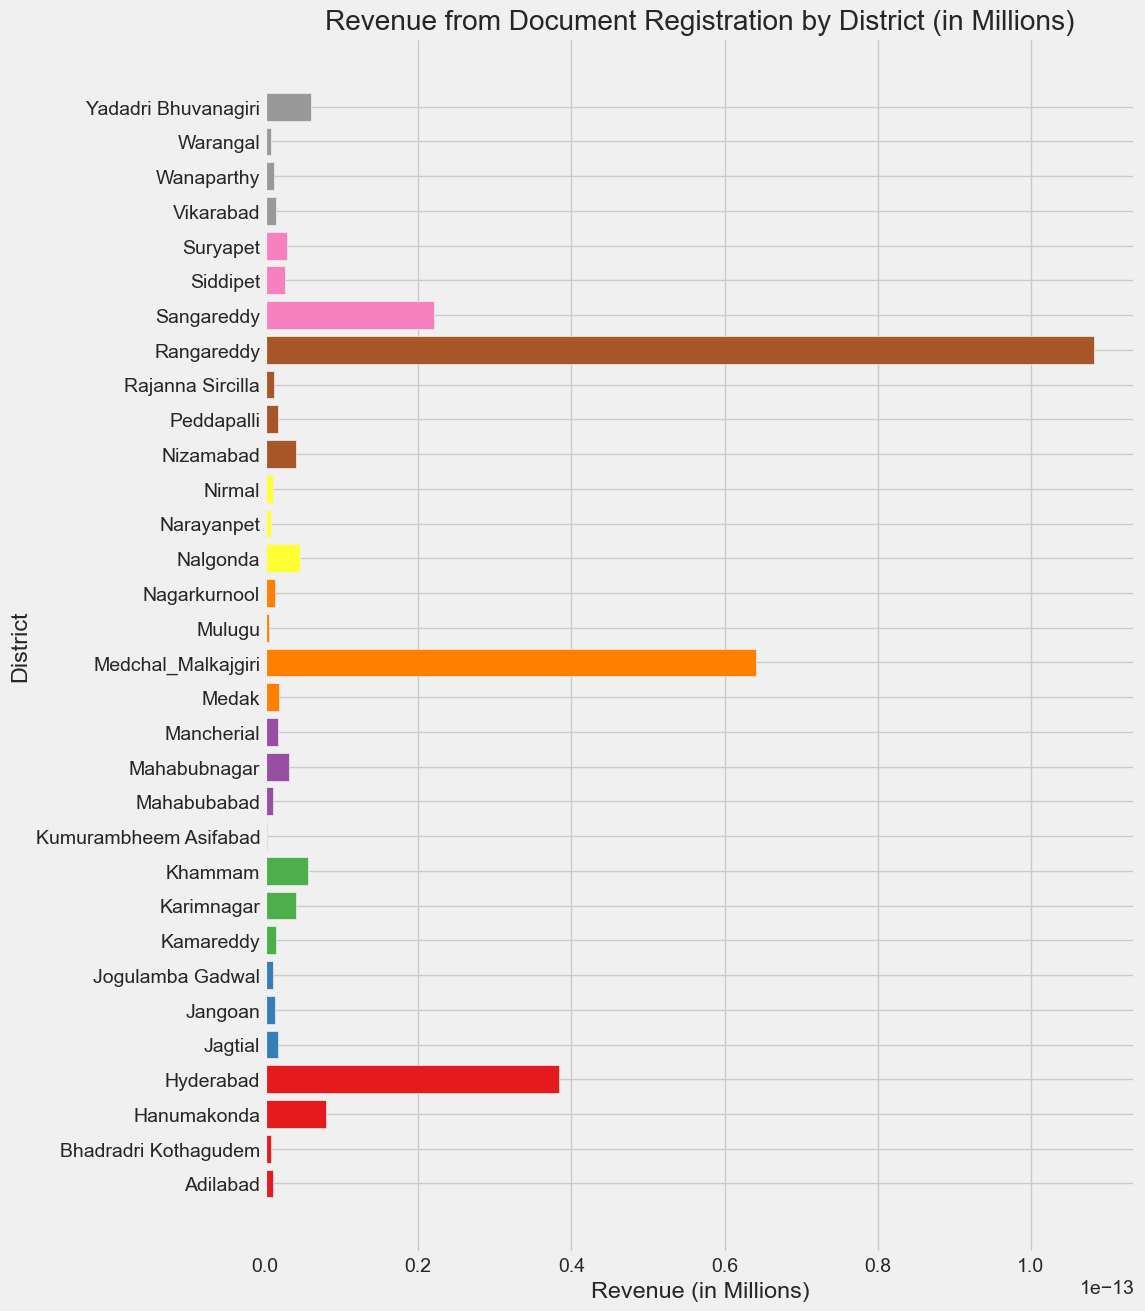

In [68]:
# Set the color palette
colors = plt.cm.Set1(np.linspace(0, 1, len(districts_revenue)))

plt.figure(figsize=(10, 15))  # Adjust the figure size

# Create horizontal bar plot
bars = plt.barh(districts_revenue['district'], 
                districts_revenue['documents_registered_rev'], 
                color=colors)

# Set title and labels
plt.title('Revenue from Document Registration by District (in Millions)')
plt.xlabel('Revenue (in Millions)')
plt.ylabel('District')

# Display the plot
plt.show()

### Calculate Revenue Growth

To calculate the revenue growth between FY 2019 and FY 2022 for each district, follow these steps:

1. **Filter Data for FY 2019 and FY 2022:** Start by filtering the data to include only the financial data for the fiscal years 2019 and 2022.

2. **Calculate the Growth Rate:** Use the following formula to calculate the revenue growth rate:

$$
\text{Growth Rate} = \frac{\text{Revenue in 2022} - \text{Revenue in 2019}}{\text{Revenue in 2019}} \times 100
$$


In [69]:
stamps.head()

,id,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,district,mmm,quarter,fiscal_year
0,1,2019-04-01,4533,59236363.0,0,0.0,Mahabubnagar,Apr,Q1,2019
1,2,2019-04-01,4151,41508762.0,0,0.0,Siddipet,Apr,Q1,2019
2,3,2019-04-01,2116,23674170.0,0,0.0,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,1089,15915285.0,0,0.0,Mahabubabad,Apr,Q1,2019
4,5,2019-04-01,6133,82593256.0,0,0.0,Nalgonda,Apr,Q1,2019


In [74]:
# Filter data for FY 2019 and FY 2022
revenue_2019 = stamps[stamps['fiscal_year'] == 2019].groupby('district')['documents_registered_rev'].sum().reset_index()
revenue_2019.columns = ['district', 'documents_registered_rev_2019']

revenue_2022 = stamps[stamps['fiscal_year'] == 2022].groupby('district')['documents_registered_rev'].sum().reset_index()
revenue_2022.columns = ['district', 'documents_registered_rev_2022']

# Merge the two dataframes on 'district'
merged_revenue = revenue_2019.merge(revenue_2022, on='district')

# Calculate growth rate
merged_revenue['growth_rate'] = ((merged_revenue['documents_registered_rev_2022'] - merged_revenue['documents_registered_rev_2019']) / merged_revenue['documents_registered_rev_2019']) * 100

In [75]:
# Sort by growth rate and display top 5 districts
top_5_districts = merged_revenue.sort_values(by='growth_rate', ascending=False).head(5)
top_5_districts[['district', 'growth_rate']]

,district,growth_rate
16,Mulugu,170.937720
0,Adilabad,122.841346
8,Karimnagar,92.745530
13,Mancherial,91.749143
15,Medchal_Malkajgiri,91.684370


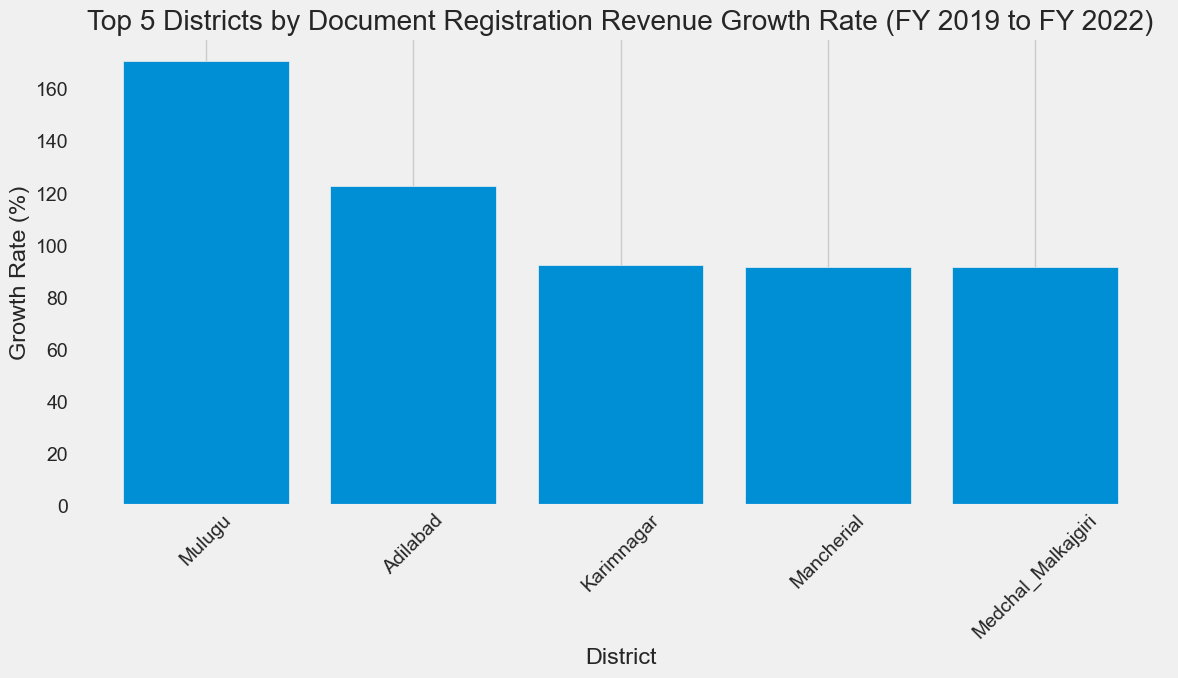

In [77]:
# Sort by growth rate and get top 5 districts
top_5_districts = merged_revenue.sort_values(by='growth_rate', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 7))
plt.bar(top_5_districts['district'], top_5_districts['growth_rate'])
plt.xlabel('District')
plt.ylabel('Growth Rate (%)')
plt.title('Top 5 Districts by Document Registration Revenue Growth Rate (FY 2019 to FY 2022)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()